In [174]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nltk.corpus import stopwords
import pickle

from collections import Counter

import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

import spacy

from spacy.language import Language

from spacy_language_detection import LanguageDetector

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/generated-inputs/test1.csv
/kaggle/input/generated-inputs/train1.csv
/kaggle/input/dataaa/train2.csv


In [175]:
train = pd.read_csv('/kaggle/input/dataaa/train2.csv')
train.drop_duplicates(subset=['name'], inplace=True)

In [158]:
Counter(train['label'])

Counter({1.0: 101, 0.0: 634})

In [159]:
stop_words = stopwords.words('english')

In [160]:
train.to_csv('/kaggle/working/train_data.csv',index=False)

In [161]:
for text, label in zip(train.name, train.label):
    if label not in [0, 1, 2]:
        print(text)

# Preprocessing

In [162]:
lemmas = []
nlp = spacy.load('en_core_web_lg')
for name in train.name:
    processed_text = nlp(name)
    lemmas.append(' '.join([token.lemma_ for token in processed_text]))

In [163]:

tfidf_features = TfidfVectorizer().fit_transform(lemmas)
vectorizer = CountVectorizer(stop_words=stop_words)
tf_features = vectorizer.fit_transform(lemmas)
labels = train.label

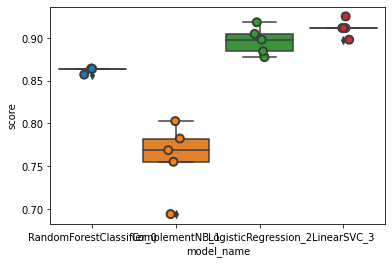

model_name
ComplementNB_1              0.760544
LinearSVC_3                 0.911565
LogisticRegression_2        0.896599
RandomForestClassifier_0    0.862585
Name: score, dtype: float64


In [164]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    # LinearSVC(max_iter=5000, class_weight='balanced'),
    ComplementNB(),
    LogisticRegression(random_state=0, max_iter=5000),
    LinearSVC(C=1.5,class_weight=None,dual=True,loss='hinge',max_iter=6009,multi_class='crammer_singer',penalty='l1',random_state=21)
    # LinearSVC(max_iter=5000, random_state=21, C=1.5,  penalty="l1", dual=False, class_weight="balanced")
]
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=69420)
entries = []
_scoring = make_scorer(recall_score, average="weighted")

for i, model in enumerate(models):
  model_name = f"{model.__class__.__name__}_{i}"
  scores = cross_val_score(model, tf_features, labels, scoring=_scoring, cv=kfold)
  for fold_idx, score in enumerate(scores):
    entries.append((model_name, fold_idx, score))

cv_df = pd.DataFrame(entries, columns=["model_name", "fold_idx", "score"])
sns.boxplot(x="model_name", y="score", data=cv_df)
sns.stripplot(x="model_name", y="score", data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()
print(cv_df.groupby("model_name").score.mean())

# LinearSVC confusion matrix - need more data

In [ ]:
vectorizer = CountVectorizer(decode_error="replace",vocabulary=pickle.load(open("feature.pkl", "rb")))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(tf_features, labels, test_size=0.3, stratify=labels, shuffle=True)
model = LinearSVC(C=1.5,class_weight=None,dual=True,loss='hinge',max_iter=6009,multi_class='crammer_singer',penalty='l1',random_state=21)
model.fit(X_train, Y_train)
preds = model.predict(X_test)
c_m = confusion_matrix(Y_test, preds, labels=model.classes_)
disp = ConfusionMatrixDisplay(c_m, display_labels=model.classes_)
disp.plot()
plt.show()

# Saving trained model

In [166]:
pickle.dump(vectorizer.vocabulary_, open('/kaggle/working/trained_vect.pkl', 'wb'))

In [167]:
pickle.dump(model, open('/kaggle/working/trained_model.pkl', 'wb'))

# Hyperparameter tuning

In [ ]:
model = LinearSVC()
params = {  "penalty": ["l1","l2"],
            "dual": [True, False],
            "max_iter": [6009],
            "C": [0.5, 1, 1.5, 5],
            "loss": ['hinge', 'squared_hinge'],
            "multi_class": ["ovr", "crammer_singer"],
            "class_weight": ["balanced", None],
            "random_state": [21]
} 
clf = GridSearchCV(model, params, scoring=_scoring, cv=kfold, return_train_score=True, n_jobs=-1, verbose=2)
clf.fit(tf_features, labels)

In [126]:
clf.best_params_


{'C': 1.5,
 'class_weight': None,
 'dual': True,
 'loss': 'hinge',
 'max_iter': 6009,
 'multi_class': 'crammer_singer',
 'penalty': 'l1',
 'random_state': 21}